In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels as stm

from sklearn.datasets import load_breast_cancer, load_iris
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

%matplotlib inline

In [2]:
pd.set_option('display.max_rows',151)

#### **Datasets**

In [3]:
cancer_dataset, iris_dataset = load_breast_cancer(), load_iris()

##### **1. Cancer Dataset**
##### **Segregating Features and Labels**

In [4]:
X_cancer_df = pd.DataFrame(cancer_dataset.data, columns=cancer_dataset.feature_names)
y_cancer_df = pd.DataFrame(cancer_dataset.target, columns=['Label'])

In [5]:
X_cancer_df.shape

(569, 30)

In [6]:
cancer_dataset.target_names

array(['malignant', 'benign'], dtype='<U9')

In [7]:
y_cancer_df.shape, y_cancer_df.value_counts()

((569, 1),
 Label
 1        357
 0        212
 dtype: int64)

##### **2. Iris Dataset**
##### **Segregating Features and Labels**

In [8]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

# ***`Outlier Detection`***
- ***We want to find the outliers in the given dataset or make the train dataset outliers free.***

### **As LOF totally relies on distance calculations thus I'm standardizing the features because higher data values can easily skew/shift the results.**

In [9]:
X_iris_df = pd.DataFrame(iris_dataset.data,columns=iris_dataset.feature_names)
y_iris_df = pd.DataFrame(iris_dataset.target,columns=['Label'])

In [10]:
X_iris_df = ss.fit_transform(X=X_iris_df)

In [11]:
X_iris_df = pd.DataFrame(X_iris_df,columns=iris_dataset.feature_names)

In [12]:
X_iris_df.shape, X_iris_df.head()

((150, 4),
    sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
 0          -0.900681          1.019004          -1.340227         -1.315444
 1          -1.143017         -0.131979          -1.340227         -1.315444
 2          -1.385353          0.328414          -1.397064         -1.315444
 3          -1.506521          0.098217          -1.283389         -1.315444
 4          -1.021849          1.249201          -1.340227         -1.315444)

In [13]:
iris_dataset.target.shape, iris_dataset.target_names

((150,), array(['setosa', 'versicolor', 'virginica'], dtype='<U10'))

In [14]:
y_iris_df.shape, y_iris_df.value_counts()

((150, 1),
 Label
 2        50
 1        50
 0        50
 dtype: int64)

#### **Using LOF to find outliers in IRIS Dataset**
### **`CASE-I` :: Neighbors = 20  &  Contamination = 0.05 or 5%  &  Leaf_Size = 15**

In [15]:
print(X_iris_df.shape)

iris_contam = 0.05
print(X_iris_df.shape[0]*iris_contam)

(150, 4)
7.5


In [16]:
lof_iris = LocalOutlierFactor(n_neighbors=20,algorithm='kd_tree',leaf_size=15,contamination=iris_contam,novelty=False)

In [17]:
lof_iris_pred = lof_iris.fit_predict(X_iris_df)
lof_iris_pred.shape

(150,)

In [18]:
pred_dict = {1:0, -1:1}
lof_iris_pred = [pred_dict.get(val) for val in lof_iris_pred]

#### **Here, LOF returns the results in the form of [1, -1] where 1's are considered as inliers and -1 are considered as Outliers.**

In [19]:
np.unique(lof_iris_pred), np.bincount(lof_iris_pred)

(array([0, 1]), array([142,   8], dtype=int64))

In [20]:
lof_iris_vals = lof_iris.negative_outlier_factor_          ## -ve lof value

#### **LOF will always returns the -ve factor score and the inliers generally have score close to 1 i.e. close to -1, whereas Outliers tends to have a larger score.**

In [21]:
lof_iris_offset = lof_iris.offset_        ## Threshold Value
lof_iris_offset

-1.441204834844254

#### **This is the negative threshold value generated by LOF if any value is greater than it then such a record will be considered as an Outlier.**

In [22]:
iris_lof_result = pd.concat([X_iris_df,y_iris_df,
           pd.DataFrame(lof_iris_vals,columns=['LOF_Values']),
           pd.DataFrame(lof_iris_pred,columns=['LOF_Tags'])],axis=1)

In [23]:
iris_lof_result[iris_lof_result['LOF_Values'] < lof_iris_offset]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Label,LOF_Values,LOF_Tags
14,-0.052506,2.169988,-1.453901,-1.315444,0,-1.495164,1
15,-0.173674,3.090775,-1.283389,-1.052180,0,-2.068567,1
32,-0.779513,2.400185,-1.283389,-1.447076,0,-1.456299,1
33,-0.416010,2.630382,-1.340227,-1.315444,0,-1.637883,1
41,-1.627688,-1.743357,-1.397064,-1.183812,0,-1.912040,1
117,2.249683,1.709595,1.672157,1.317199,2,-1.822850,1
118,2.249683,-1.052767,1.785832,1.448832,2,-1.602136,1
131,2.492019,1.709595,1.501645,1.053935,2,-1.883861,1


#### **Now, if we see the -ve scores then they are not so highly away or larger than the offset value but if we compare these values with -1 then yes the above records are a bit away from the generally considered inliers.**
- Here, the dataset was not having any labels for the outliers, so this is completely driven based on distance calculation
- Plotting the records with above generated score will tell the better story

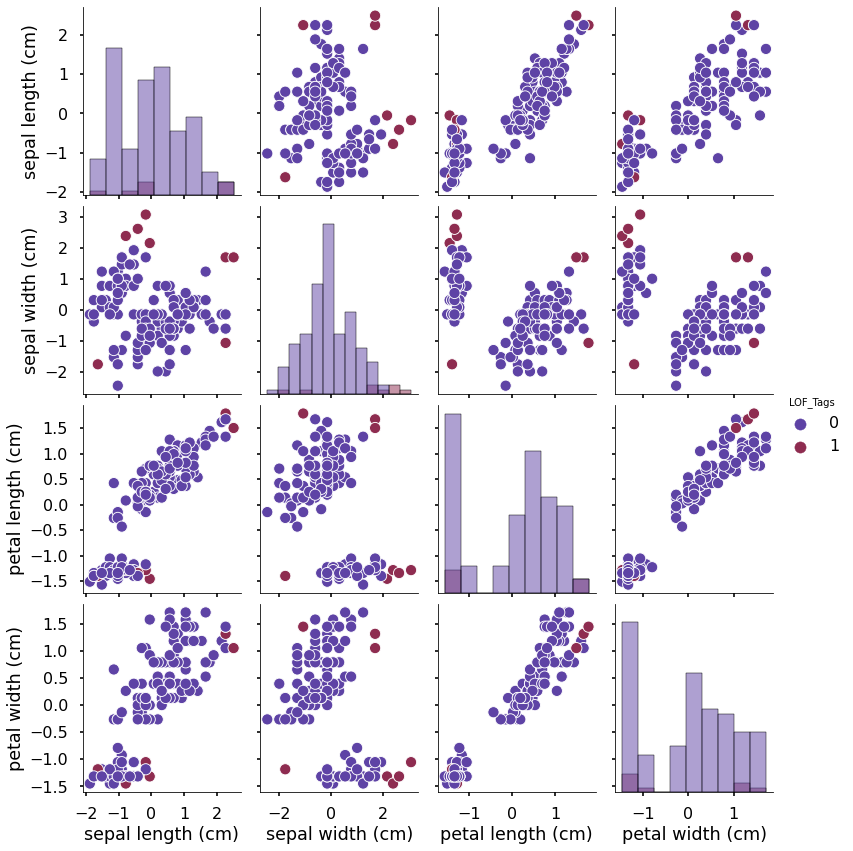

In [24]:
with plt.style.context('seaborn-poster'):
    g = sns.pairplot(data=iris_lof_result[['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)','LOF_Tags']],
                 hue='LOF_Tags',palette='twilight',height=3,aspect=0.9,diag_kind='hist')

#### **As, the plot is self-explanatory because the data points which are away(separated from others) from the clusters or at the edges/boundaries of it are labelled as Outliers. This is exactly the way LOF behaves.**

#### **More analysis**

In [25]:
iris_lof_result.columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)', 'Label', 'LOF_Values', 'LOF_Tags'],
      dtype='object')

In [26]:
def lbl(val):
    if val == 1:
        return 'Outliers'
    else:
        return 'Inliers'

In [27]:
iris_lof_result['LOF_Tags_Class'] = iris_lof_result['LOF_Tags'].apply(lambda val: lbl(val))

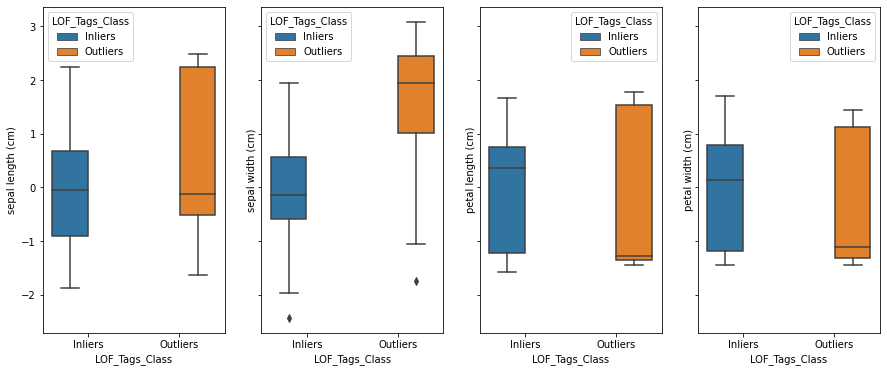

In [28]:
fig, ax = plt.subplots(1,4,sharex=True,sharey=True,squeeze=True,figsize=(15,6))
sns.boxplot(data=iris_lof_result,x='LOF_Tags_Class',y='sepal length (cm)',hue='LOF_Tags_Class',ax=ax[0])
sns.boxplot(data=iris_lof_result,x='LOF_Tags_Class',y='sepal width (cm)',hue='LOF_Tags_Class',ax=ax[1])
sns.boxplot(data=iris_lof_result,x='LOF_Tags_Class',y='petal length (cm)',hue='LOF_Tags_Class',ax=ax[2])
sns.boxplot(data=iris_lof_result,x='LOF_Tags_Class',y='petal width (cm)',hue='LOF_Tags_Class',ax=ax[3])
plt.show()

In [29]:
iris_lof_result.groupby(['LOF_Tags_Class'])[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)','petal width (cm)']].min()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
LOF_Tags_Class,,,,
Inliers,-1.870024,-2.433947,-1.567576,-1.447076
Outliers,-1.627688,-1.743357,-1.453901,-1.447076


In [30]:
iris_lof_result.groupby(['LOF_Tags_Class'])[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)','petal width (cm)']].median()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
LOF_Tags_Class,,,,
Inliers,-0.052506,-0.131979,0.364896,0.132510
Outliers,-0.113090,1.939791,-1.283389,-1.117996


In [31]:
iris_lof_result.groupby(['LOF_Tags_Class'])[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)','petal width (cm)']].max()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
LOF_Tags_Class,,,,
Inliers,2.249683,1.939791,1.672157,1.712096
Outliers,2.492019,3.090775,1.785832,1.448832


#### **So, Sepal width, Petal Length and Petal Width has some good point variations in the 5 number summary of Inliers and Outliers. Also, the maximum value of the features is quite high in Outliers other than Petal Width.**

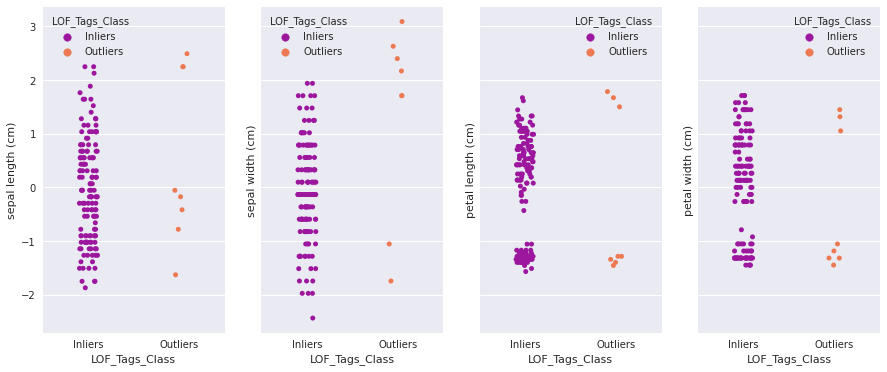

In [32]:
with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1,4,figsize=(15,6),sharex=True,sharey=True)
    sns.stripplot(data=iris_lof_result,x='LOF_Tags_Class',y='sepal length (cm)',hue='LOF_Tags_Class',palette='plasma',ax=ax[0])
    sns.stripplot(data=iris_lof_result,x='LOF_Tags_Class',y='sepal width (cm)',hue='LOF_Tags_Class',palette='plasma',ax=ax[1])
    sns.stripplot(data=iris_lof_result,x='LOF_Tags_Class',y='petal length (cm)',hue='LOF_Tags_Class',palette='plasma',ax=ax[2])
    sns.stripplot(data=iris_lof_result,x='LOF_Tags_Class',y='petal width (cm)',hue='LOF_Tags_Class',palette='plasma',ax=ax[3])

#### **If we look at the outliers then they are clearly the extreme points which are either at the edges or boundaries of the clusters.**

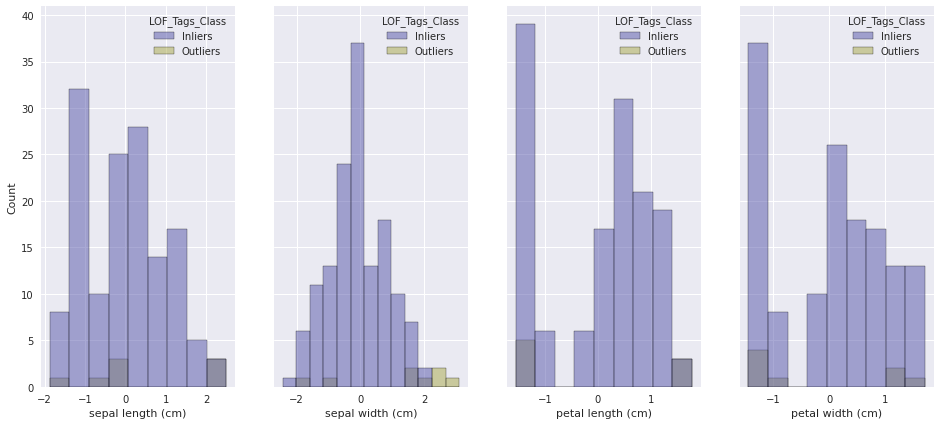

In [33]:
with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1,4,figsize=(16,7),sharex=False,sharey=True)
    sns.histplot(data=iris_lof_result,x='sepal length (cm)',hue='LOF_Tags_Class',palette='gist_stern',ax=ax[0])
    sns.histplot(data=iris_lof_result,x='sepal width (cm)',hue='LOF_Tags_Class',palette='gist_stern',ax=ax[1])
    sns.histplot(data=iris_lof_result,x='petal length (cm)',hue='LOF_Tags_Class',palette='gist_stern',ax=ax[2])
    sns.histplot(data=iris_lof_result,x='petal width (cm)',hue='LOF_Tags_Class',palette='gist_stern',ax=ax[3])

#### **Some gaps are quite evident in the above plots and point to mention here is that majority of the outliers are from the extreme values of features.**

In [34]:
iris_classes = {0:'setosa',1:'versicolor',2:'virginica'}
iris_lof_result['Label'] = iris_lof_result['Label'].apply(lambda val : iris_classes.get(val))

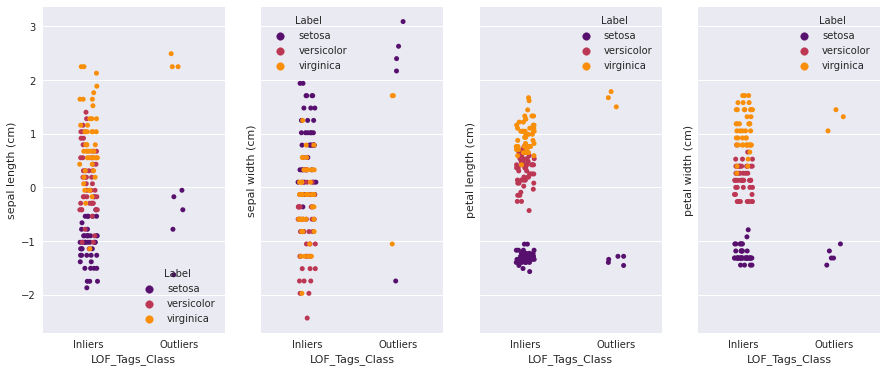

In [35]:
with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1,4,figsize=(15,6),sharex=True,sharey=True)
    sns.stripplot(data=iris_lof_result,x='LOF_Tags_Class',y='sepal length (cm)',hue='Label',palette='inferno',ax=ax[0])
    sns.stripplot(data=iris_lof_result,x='LOF_Tags_Class',y='sepal width (cm)',hue='Label',palette='inferno',ax=ax[1])
    sns.stripplot(data=iris_lof_result,x='LOF_Tags_Class',y='petal length (cm)',hue='Label',palette='inferno',ax=ax[2])
    sns.stripplot(data=iris_lof_result,x='LOF_Tags_Class',y='petal width (cm)',hue='Label',palette='inferno',ax=ax[3])

#### **In this case with `contamination == 0.05` and `20 NN`, based on that LOF looks to work good in capturing the local and overall outliers. No outliers been selected from Versicolor class.**

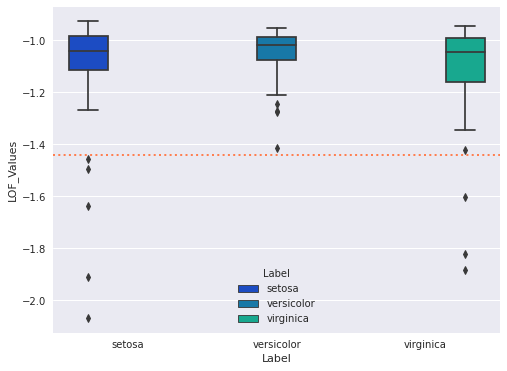

In [36]:
with plt.style.context('seaborn'):
    plt.figure(figsize=(8,6))
    sns.boxplot(data=iris_lof_result,x='Label',y='LOF_Values',hue='Label',palette='winter')
    plt.axhline(lof_iris_offset,color='coral',linestyle=':',linewidth=2)

#### **The LOF value in Versicolor is less than the offset value thus no outliers in this class.**

### **`CASE-II` :: Neighbors = 20  &  Contamination = 0.1 or 1%  &  Leaf_Size = 15**

In [37]:
iris_contam = 0.1
lof_iris = LocalOutlierFactor(n_neighbors=20,algorithm='kd_tree',leaf_size=15,contamination=iris_contam,novelty=False)

In [38]:
lof_iris_pred = lof_iris.fit_predict(X_iris_df)
lof_iris_pred.shape

(150,)

In [39]:
pred_dict = {1:0, -1:1}          # LOF returns the results in form of [1, -1] ; 1's are considered as inliers and -1 as Outliers
lof_iris_pred = [pred_dict.get(val) for val in lof_iris_pred]

In [40]:
np.unique(lof_iris_pred), np.bincount(lof_iris_pred)

(array([0, 1]), array([135,  15], dtype=int64))

In [41]:
lof_iris_vals = lof_iris.negative_outlier_factor_          ## -ve lof value

In [42]:
lof_iris_offset = lof_iris.offset_        ## Threshold Value
lof_iris_offset

-1.2620938453558437

#### **The new offset value with higher percentage of contamination has increased quite significantly.**

In [43]:
iris_lof_result = pd.concat([X_iris_df,y_iris_df,
           pd.DataFrame(lof_iris_vals,columns=['LOF_Values']),
           pd.DataFrame(lof_iris_pred,columns=['LOF_Tags'])],axis=1)

In [44]:
iris_lof_result[iris_lof_result['LOF_Values'] < lof_iris_offset]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Label,LOF_Values,LOF_Tags
5,-0.537178,1.939791,-1.169714,-1.052180,0,-1.267143,1
14,-0.052506,2.169988,-1.453901,-1.315444,0,-1.495164,1
15,-0.173674,3.090775,-1.283389,-1.052180,0,-2.068567,1
32,-0.779513,2.400185,-1.283389,-1.447076,0,-1.456299,1
33,-0.416010,2.630382,-1.340227,-1.315444,0,-1.637883,1
41,-1.627688,-1.743357,-1.397064,-1.183812,0,-1.912040,1
57,-1.143017,-1.513160,-0.260315,-0.262387,1,-1.271099,1
60,-1.021849,-2.433947,-0.146641,-0.262387,1,-1.414394,1
93,-1.021849,-1.743357,-0.260315,-0.262387,1,-1.277357,1
105,2.128516,-0.131979,1.615320,1.185567,2,-1.272987,1


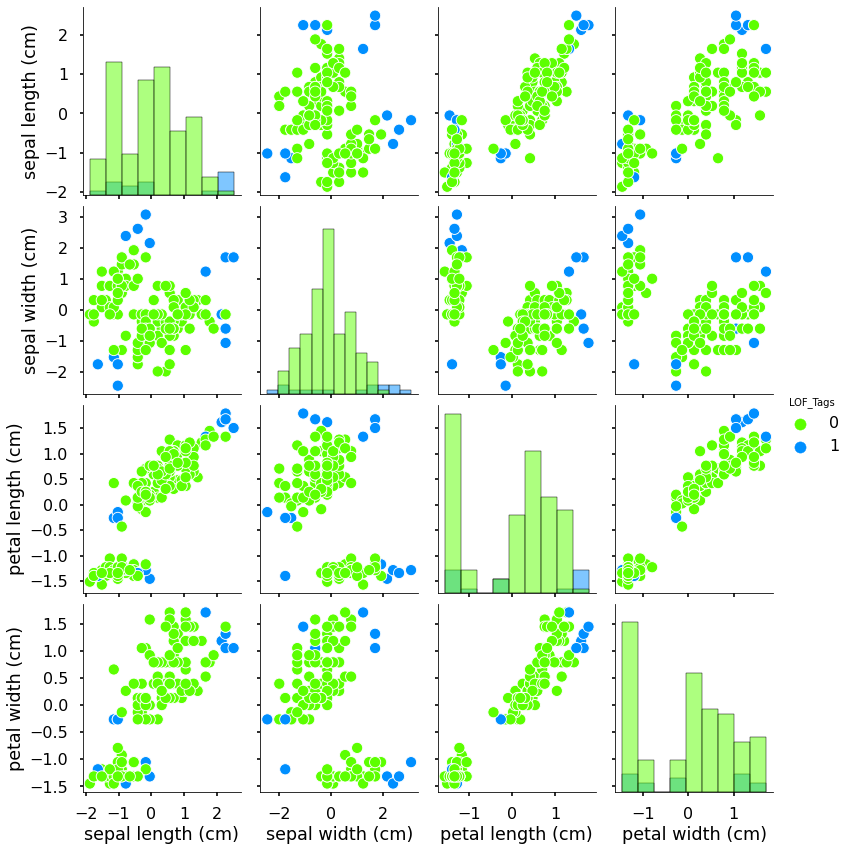

In [45]:
with plt.style.context('seaborn-poster'):
    g = sns.pairplot(data=iris_lof_result[['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)','LOF_Tags']],
                 hue='LOF_Tags',palette='gist_rainbow',height=3,aspect=0.9,diag_kind='hist')

#### **Outliers marking has become a bit aggressive in this case as some of the points near to the clusters are also marked as outliers.**

#### **More analysis**

In [46]:
iris_lof_result.columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)', 'Label', 'LOF_Values', 'LOF_Tags'],
      dtype='object')

In [47]:
iris_lof_result['LOF_Tags_Class'] = iris_lof_result['LOF_Tags'].apply(lambda val: lbl(val))

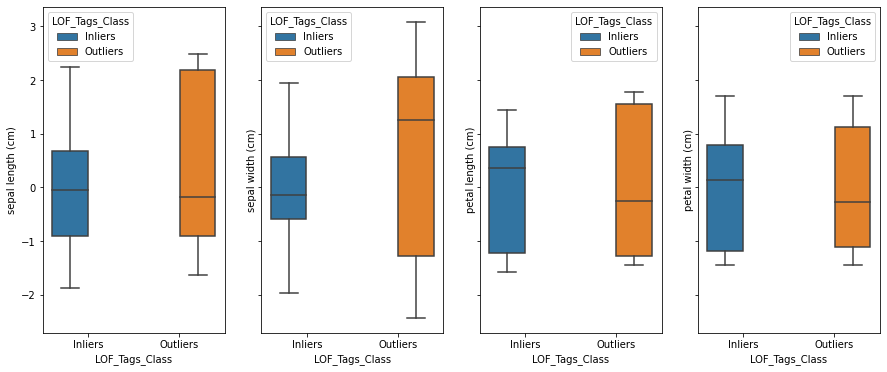

In [48]:
fig, ax = plt.subplots(1,4,sharex=True,sharey=True,squeeze=True,figsize=(15,6))
sns.boxplot(data=iris_lof_result,x='LOF_Tags_Class',y='sepal length (cm)',hue='LOF_Tags_Class',ax=ax[0])
sns.boxplot(data=iris_lof_result,x='LOF_Tags_Class',y='sepal width (cm)',hue='LOF_Tags_Class',ax=ax[1])
sns.boxplot(data=iris_lof_result,x='LOF_Tags_Class',y='petal length (cm)',hue='LOF_Tags_Class',ax=ax[2])
sns.boxplot(data=iris_lof_result,x='LOF_Tags_Class',y='petal width (cm)',hue='LOF_Tags_Class',ax=ax[3])
plt.show()

In [49]:
iris_lof_result.groupby(['LOF_Tags_Class'])[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)','petal width (cm)']].min()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
LOF_Tags_Class,,,,
Inliers,-1.870024,-1.973554,-1.567576,-1.447076
Outliers,-1.627688,-2.433947,-1.453901,-1.447076


In [50]:
iris_lof_result.groupby(['LOF_Tags_Class'])[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)','petal width (cm)']].median()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
LOF_Tags_Class,,,,
Inliers,-0.052506,-0.131979,0.364896,0.132510
Outliers,-0.173674,1.249201,-0.260315,-0.262387


In [51]:
iris_lof_result.groupby(['LOF_Tags_Class'])[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)','petal width (cm)']].max()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
LOF_Tags_Class,,,,
Inliers,2.249683,1.939791,1.444807,1.712096
Outliers,2.492019,3.090775,1.785832,1.712096


#### **Above boxplots shows us some good amount of variations in features other than Petal Width.**

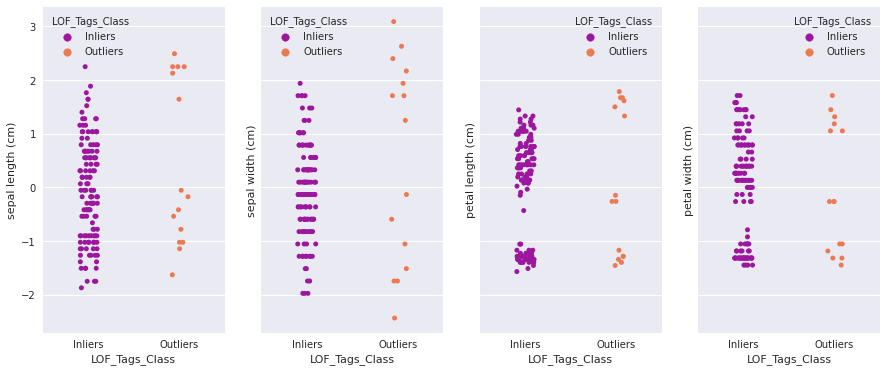

In [52]:
with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1,4,figsize=(15,6),sharex=True,sharey=True)
    sns.stripplot(data=iris_lof_result,x='LOF_Tags_Class',y='sepal length (cm)',hue='LOF_Tags_Class',palette='plasma',ax=ax[0])
    sns.stripplot(data=iris_lof_result,x='LOF_Tags_Class',y='sepal width (cm)',hue='LOF_Tags_Class',palette='plasma',ax=ax[1])
    sns.stripplot(data=iris_lof_result,x='LOF_Tags_Class',y='petal length (cm)',hue='LOF_Tags_Class',palette='plasma',ax=ax[2])
    sns.stripplot(data=iris_lof_result,x='LOF_Tags_Class',y='petal width (cm)',hue='LOF_Tags_Class',palette='plasma',ax=ax[3])

#### **One thing to mention here is that as seen in the plots with contamination == 0.05, the outliers are picked from the same or nearby region with contamination == 0.1**

In [53]:
iris_classes = {0:'setosa',1:'versicolor',2:'virginica'}
iris_lof_result['Label'] = iris_lof_result['Label'].apply(lambda val : iris_classes.get(val))

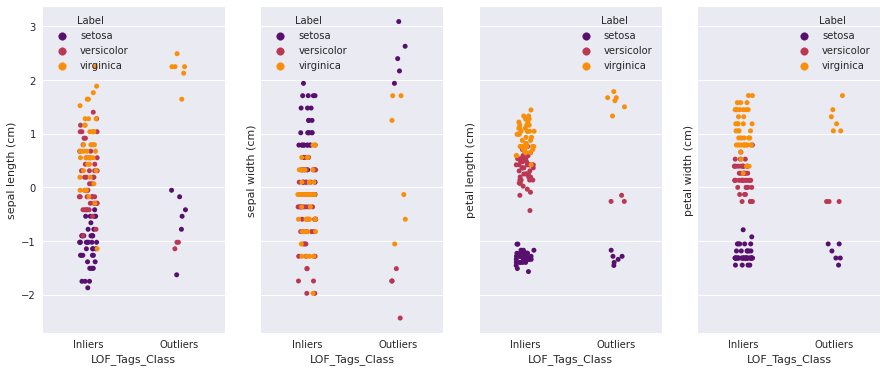

In [54]:
with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1,4,figsize=(15,6),sharex=True,sharey=True)
    sns.stripplot(data=iris_lof_result,x='LOF_Tags_Class',y='sepal length (cm)',hue='Label',palette='inferno',ax=ax[0])
    sns.stripplot(data=iris_lof_result,x='LOF_Tags_Class',y='sepal width (cm)',hue='Label',palette='inferno',ax=ax[1])
    sns.stripplot(data=iris_lof_result,x='LOF_Tags_Class',y='petal length (cm)',hue='Label',palette='inferno',ax=ax[2])
    sns.stripplot(data=iris_lof_result,x='LOF_Tags_Class',y='petal width (cm)',hue='Label',palette='inferno',ax=ax[3])

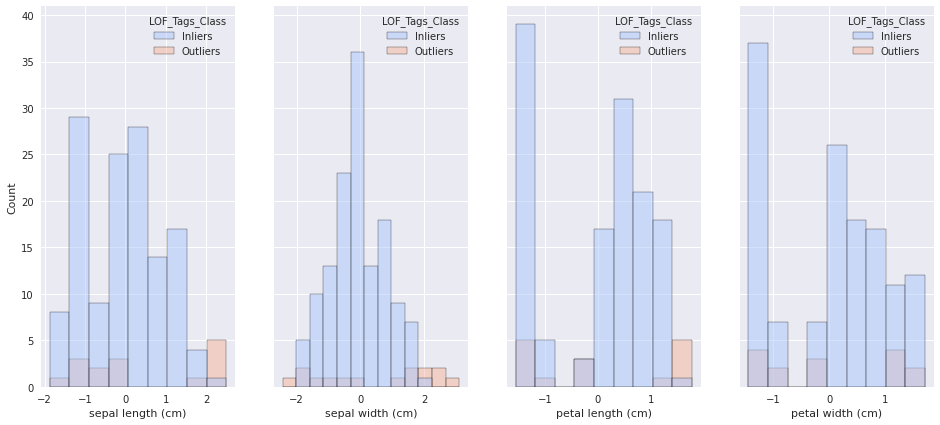

In [55]:
with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1,4,figsize=(16,7),sharex=False,sharey=True)
    sns.histplot(data=iris_lof_result,x='sepal length (cm)',hue='LOF_Tags_Class',palette='coolwarm',ax=ax[0])
    sns.histplot(data=iris_lof_result,x='sepal width (cm)',hue='LOF_Tags_Class',palette='coolwarm',ax=ax[1])
    sns.histplot(data=iris_lof_result,x='petal length (cm)',hue='LOF_Tags_Class',palette='coolwarm',ax=ax[2])
    sns.histplot(data=iris_lof_result,x='petal width (cm)',hue='LOF_Tags_Class',palette='coolwarm',ax=ax[3])

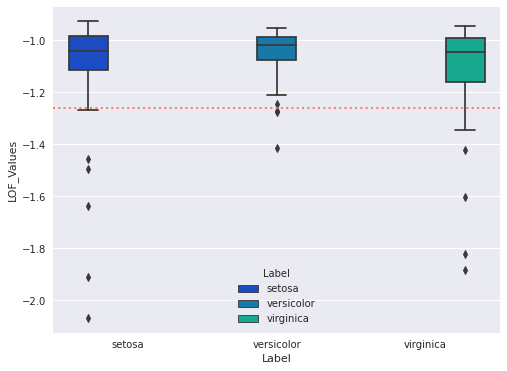

In [56]:
with plt.style.context('seaborn'):
    plt.figure(figsize=(8,6))
    sns.boxplot(data=iris_lof_result,x='Label',y='LOF_Values',hue='Label',palette='winter')
    plt.axhline(lof_iris_offset,color='coral',linestyle=':',linewidth=2)

#### **As, we can see here the offset value shifted a bit upwards thus few of the data points of Versicolor are also been labelled as Outliers.**

## **In the above analysis across both the cases, I have observed that LOF is good in capturing the local and global outliers, however there are few things which we need to take into account before using it:**
- **As it relies on distances between the points so we need to be sure with the distance metric that we are using**
    - **For example, if dataset has categorical variables then these should be handled before**
    - **Similarly, the scale has be same across features otherwise distances will gets skewed**
- **With a small dataset this can be a good approach but if we have a high dimensional data then it suffers with all the drawbacks of KNN.**

# ***`Novelty Detection`***

#### **There is a slight difference between the Outlier and Novelty Detection.**
- ***Outliers are also known as Novelty, in outlier detection we provide the dataset features in the LOF then based on it we identify the potential outliers. However, in the Novelty Detection we train the model on Outliers free dataset then fed the unseen data into it to find the outliers in the provided unseen dataset.***

In [57]:
X = iris_lof_result[iris_lof_result['LOF_Tags'] == 0][['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)']].copy(deep=True)
y = iris_lof_result[iris_lof_result['LOF_Tags'] == 0][['Label']].copy(deep=True)

In [58]:
X.shape, y.shape

((135, 4), (135, 1))

In [59]:
X_test = iris_lof_result[iris_lof_result['LOF_Tags'] == 1][['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)']].copy(deep=True)
y_test = iris_lof_result[iris_lof_result['LOF_Tags'] == 1][['Label']].copy(deep=True)

In [60]:
X_test.shape, y_test.shape

((15, 4), (15, 1))

In [61]:
novl_lof = LocalOutlierFactor(n_neighbors=25,algorithm='kd_tree',novelty=True,contamination=0.1,leaf_size=15)

In [62]:
novl_lof.fit(X)

LocalOutlierFactor(algorithm='kd_tree', contamination=0.1, leaf_size=15,
                   n_neighbors=25, novelty=True)

#### **I have used the dataset cleaned in the above Outlier Detection, so I'm using the outliers free features as a train data and the observations which were declared Outliers in the above steps as a test set.**

In [63]:
novl_lof.offset_

-1.1626892158234219

## ***When novelty is set to True be aware that you must only use predict , decision_function and score_samples on new unseen data and not on the training samples as this would lead to wrong results.***

In [64]:
novl_lof.decision_function(X_test.iloc[0:2,:])

array([-0.11498067, -0.43240855])

In [65]:
novl_lof.decision_function(X_test.iloc[:,:])

array([-0.11498067, -0.43240855, -1.15051416, -0.39325161, -0.63362476,
       -0.73168141, -0.20634848, -0.44661662, -0.19955288, -0.14510174,
       -0.24636742, -0.75098124, -0.52563824, -0.30915703, -0.83559472])

#### **For the majority of test records the `shifted opposite LOF scores` are away from 0 and all are negatives thus all are classified as Outliers. If the `shifted opposite score` is a large and positive number then it is an inlier.**

In [66]:
novl_lof.predict(X_test)

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

##### **Random Test Input**

In [67]:
novl_lof.decision_function([[1.33717756,  1.00979142, 1.16971425, 1.05217993]])

array([0.01463599])

In [68]:
novl_lof.predict([[1.33717756,  1.00979142, 1.16971425, 1.05217993]])

array([1])

#### **The shifted opposite LOF score is +ve thus Random Test Input is labelled as Inlier.**

In [69]:
novl_lof.score_samples(X_test)

array([-1.27766988, -1.59509777, -2.31320337, -1.55594082, -1.79631398,
       -1.89437063, -1.36903769, -1.60930584, -1.3622421 , -1.30779096,
       -1.40905663, -1.91367046, -1.68832746, -1.47184625, -1.99828393])

#### **This is the `opposite of LOF score` returned by score_samples the higher this score means obervation is an inlier. In our case, all the scores are -ve thus all are labelled as Outliers.**
- **The offset from training data is -1.16 and the opposite LOF score for the test data is greater than the offset value thus all are marked as Outliers.**

In [70]:
novl_lof.score_samples([[1.33717756,  1.00979142, 1.16971425, 1.05217993]])

array([-1.14805323])

- **The opposite LOF score of the random test input is less than -1.16 thus it is marked as Inlier.**

In [71]:
X['-ve_lof'] = novl_lof.negative_outlier_factor_

In [72]:
X[X['-ve_lof'] <= novl_lof.offset_].shape

(14, 5)

In [73]:
X[X['-ve_lof'] <= novl_lof.offset_]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),-ve_lof
8,-1.748856,-0.362176,-1.340227,-1.315444,-1.267974
13,-1.870024,-0.131979,-1.510739,-1.447076,-1.236249
16,-0.537178,1.939791,-1.397064,-1.052180,-1.289631
18,-0.173674,1.709595,-1.169714,-1.183812,-1.292014
38,-1.748856,-0.131979,-1.397064,-1.315444,-1.189058
62,0.189830,-1.973554,0.137547,-0.262387,-1.258150
68,0.432165,-1.973554,0.421734,0.395774,-1.226455
85,0.189830,0.788808,0.421734,0.527406,-1.182377
98,-0.900681,-1.282963,-0.430828,-0.130755,-1.297815
100,0.553333,0.558611,1.274295,1.712096,-1.165327


In [74]:
X_test['Oppo_LOF_score'] = novl_lof.score_samples(X_test)

In [75]:
X_test[X_test['Oppo_LOF_score'] < novl_lof.offset_]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Oppo_LOF_score
5,-0.537178,1.939791,-1.169714,-1.052180,-1.277670
14,-0.052506,2.169988,-1.453901,-1.315444,-1.595098
15,-0.173674,3.090775,-1.283389,-1.052180,-2.313203
32,-0.779513,2.400185,-1.283389,-1.447076,-1.555941
33,-0.416010,2.630382,-1.340227,-1.315444,-1.796314
41,-1.627688,-1.743357,-1.397064,-1.183812,-1.894371
57,-1.143017,-1.513160,-0.260315,-0.262387,-1.369038
60,-1.021849,-2.433947,-0.146641,-0.262387,-1.609306
93,-1.021849,-1.743357,-0.260315,-0.262387,-1.362242
105,2.128516,-0.131979,1.615320,1.185567,-1.307791


#### **In my analysis I found that LOF works good with a small dimensional dataset to find the local and global outliers. Few points we need to consider while working with NOVELTY DETECTION using LOF:**
- **SciKit-Learn implements two "modes" for LocalOutlierFactor, where one is unsupervised(NOVELTY=FALSE) and one is semi-supervised(NOVELTY=True).**
- **Novelty : boolean, default False By default, LocalOutlierFactor is only meant to be used for outlier detection (novelty=False). Set novelty to True if you want to use LocalOutlierFactor for novelty detection. In this case be aware that that you should only use predict, decision_function and score_samples on new unseen data and not on the training set.**